In [1]:

from numpy.random import seed 
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)
%matplotlib inline
import re

import seaborn as sns
sns.set()
import time
from wavenet_model import*


In [4]:
df = pd.read_csv('../input/train_1.csv')

In [5]:
df.shape

(145063, 551)

In [6]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


In [7]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [8]:
enc_length = train_pred_start - first_day
train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)
val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)
print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-09-02 00:00:00
Train prediction: 2016-09-03 00:00:00 - 2016-11-01 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2016-11-01 00:00:00
Val prediction: 2016-11-02 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 430
Prediction interval: 60


In [9]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])
series_array = df[df.columns[1:]].values
series_array = np.nan_to_num(series_array)

In [10]:
first_n_samples = df.shape[0]

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index,train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
#encoder_input_data = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index,train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [11]:
# convolutional operation parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 
batch_size = 2**11 #2048
epochs = 10

import time
start = time.time()
history, model = fit_wavenet(n_filters, filter_width, dilation_rates, batch_size,epochs)
print("Elapsed time = ", time.time()-start)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

Train on 116050 samples, validate on 29013 samples
Epoch 1/10
116050/116050 [==============================] - 172s 1ms/step - loss: 1.7404 - val_loss: 0.3984
Epoch 2/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.5071 - val_loss: 0.3705
Epoch 3/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4620 - val_loss: 0.3603
Epoch 4/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4387 - val_loss: 0.3555
Epoch 5/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4270 - val_loss: 0.3525
Epoch 6/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4233 - val_loss: 0.3475
Epoch 7/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4217 - val_loss: 0.3459
Epoch 8/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4201 - val_loss: 0.3462
Epoch 9/10
116050/116050 [==============================] - 152s 1ms/step - loss: 0.4

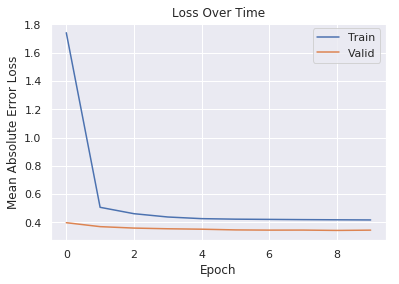

In [12]:
plot_loss(history)

In [13]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [14]:
smape_tot_array, min_smape, mean_smape, max_smape = smape_tot(encoder_input_data, decoder_target_data, 1000)
print("min: " , min_smape)
print("max: ", max_smape)
print("mean: " ,mean_smape)

min:  4.672763343398329
max:  200.0
mean:  21.452205895858707


key =  139
Sample ind:  139 Smape:  4.672763343398329


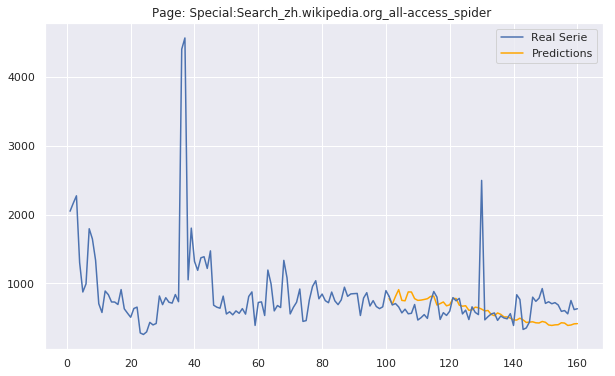

In [15]:
#min smape 
for key, value in smape_tot_array.items(): 
    if (value == min_smape): 
        print("key = ", key)
        predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=key, enc_tail_len=100)

key =  52
Sample ind:  52 Smape:  199.30724778915962
key =  54
Sample ind:  54 Smape:  199.53861032685865
key =  55
Sample ind:  55 Smape:  199.76121726290447
key =  56
Sample ind:  56 Smape:  199.65804632878934
key =  81
Sample ind:  81 Smape:  199.83173031700423
key =  163
Sample ind:  163 Smape:  199.6753539597422
key =  172
Sample ind:  172 Smape:  187.75319867093626
key =  176
Sample ind:  176 Smape:  199.97710011488022


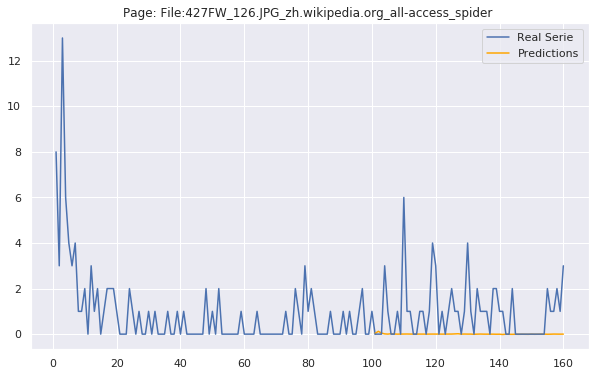

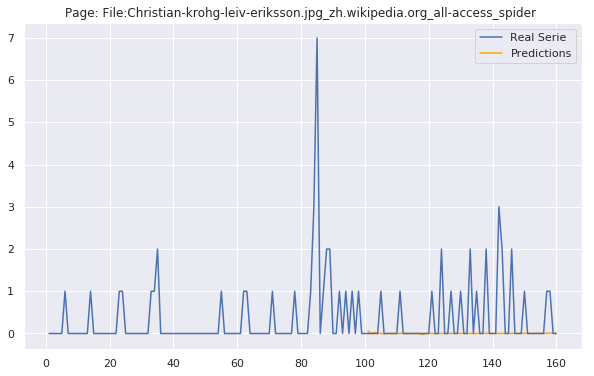

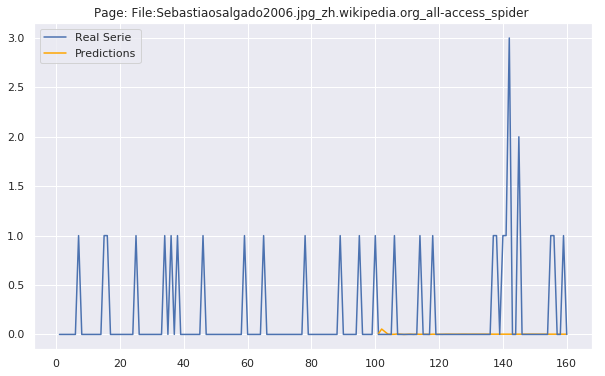

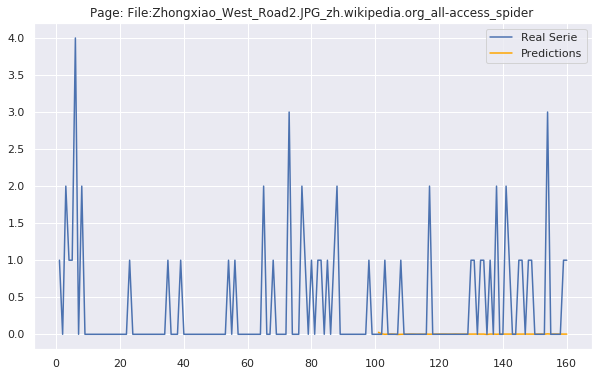

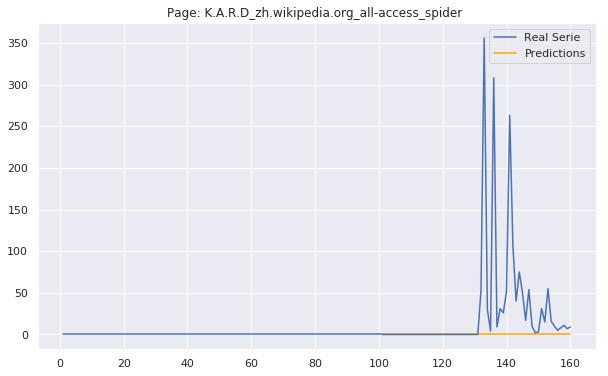

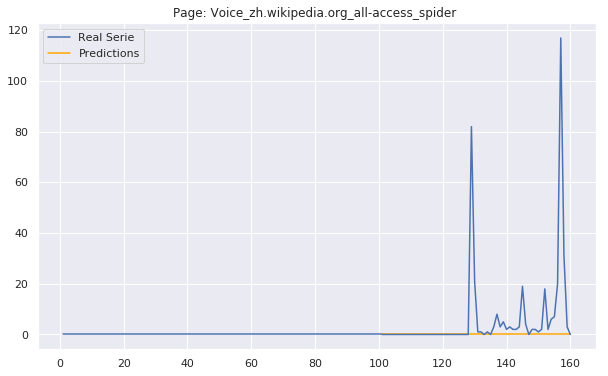

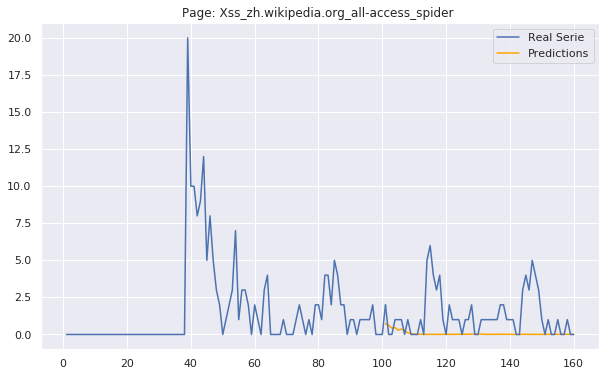

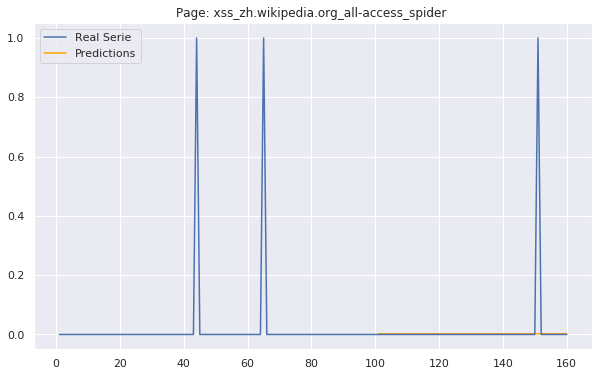

In [16]:
#pages with high smape
for key, value in smape_tot_array.items(): 
    if ((value <200) and (value > 180)): 
        print("key = ", key)
        predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=key, enc_tail_len=100)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


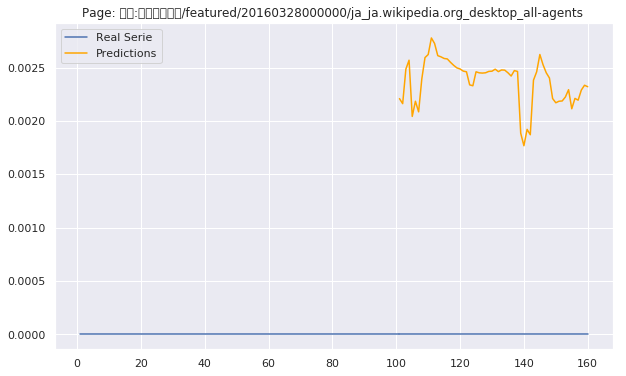

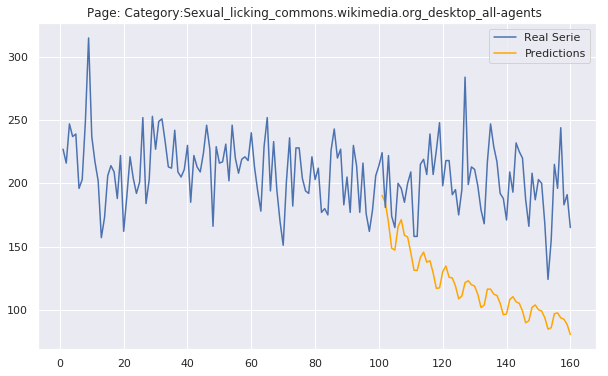

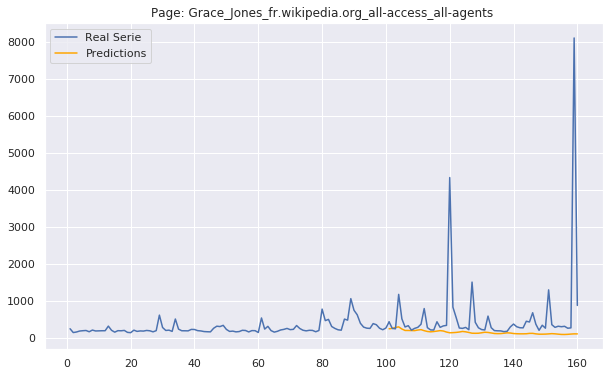

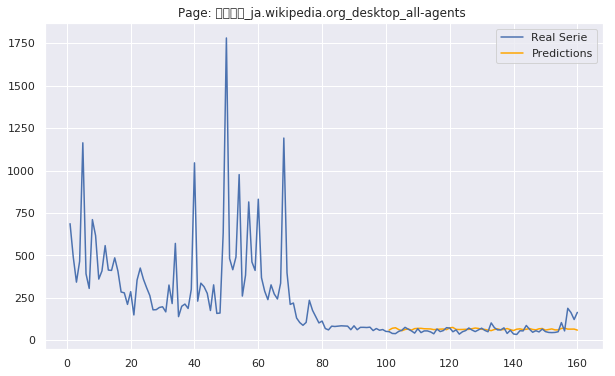

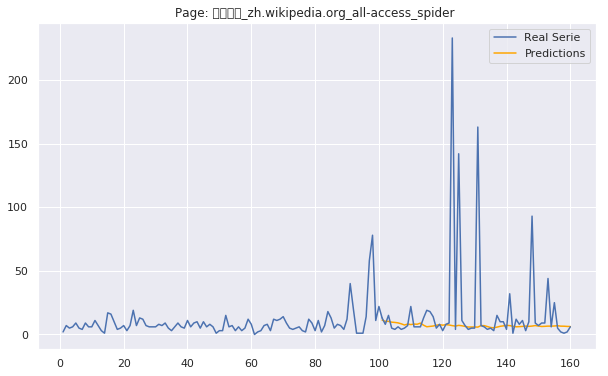

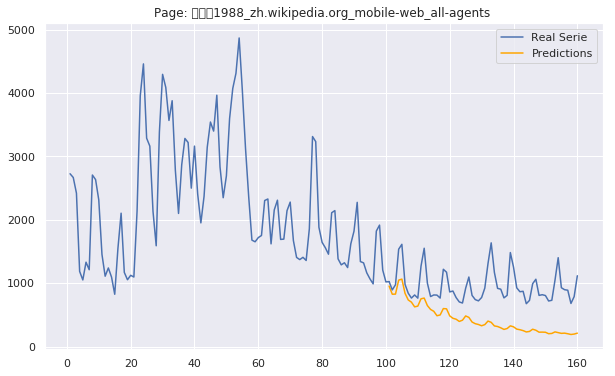

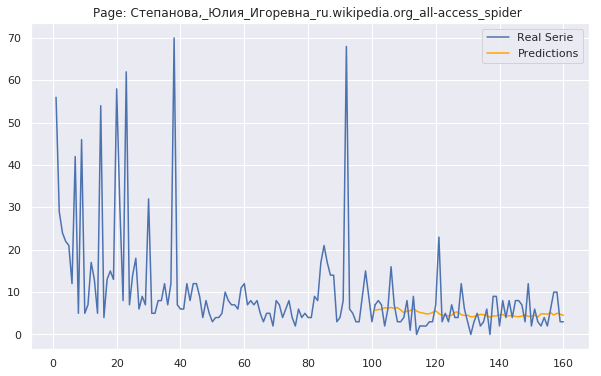

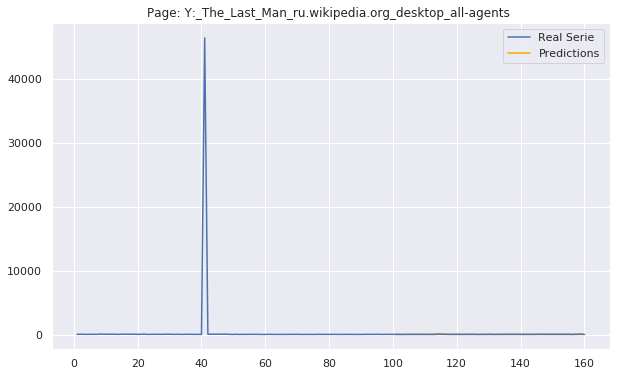

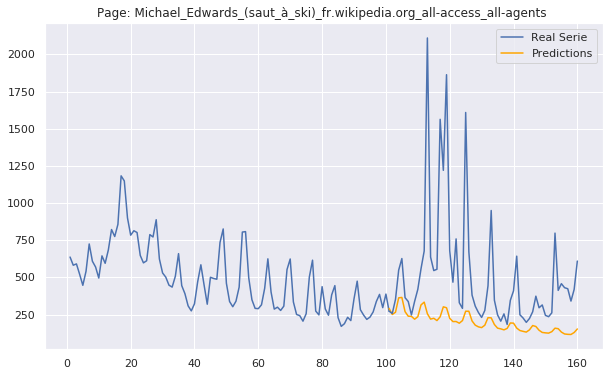

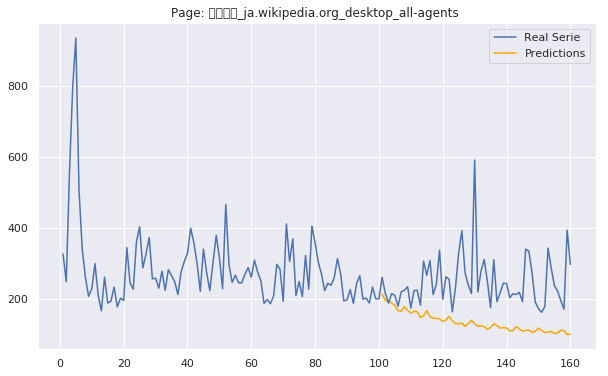

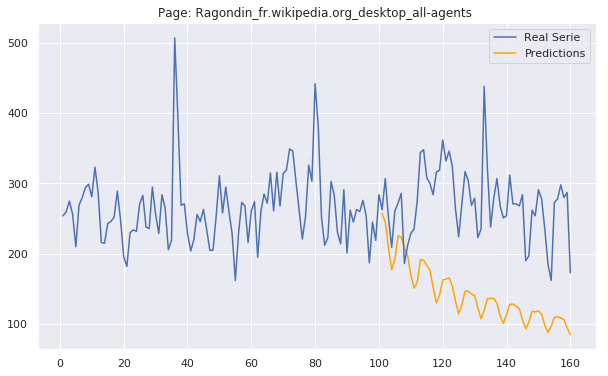

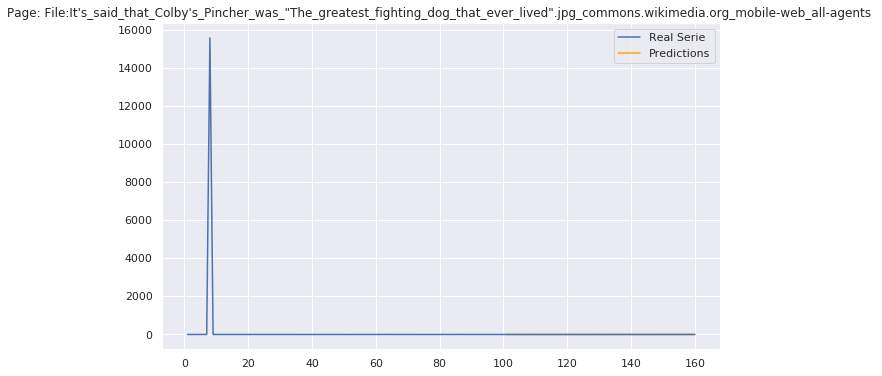

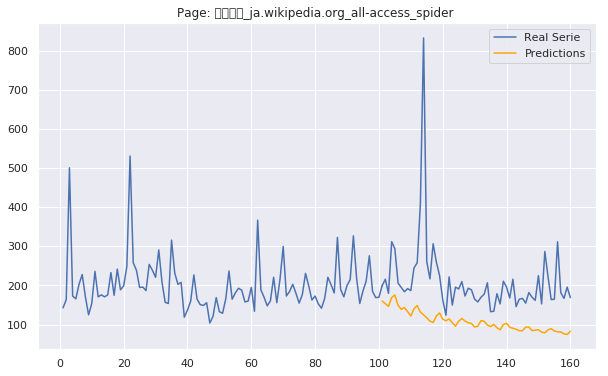

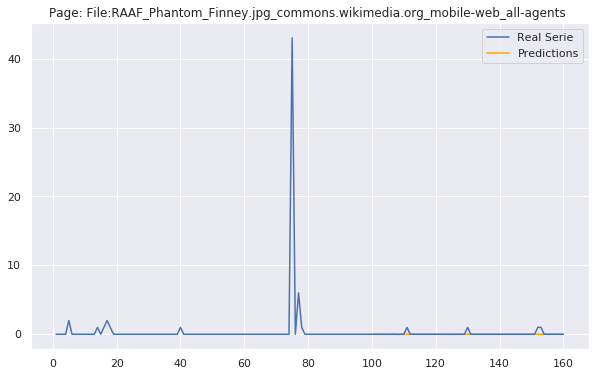

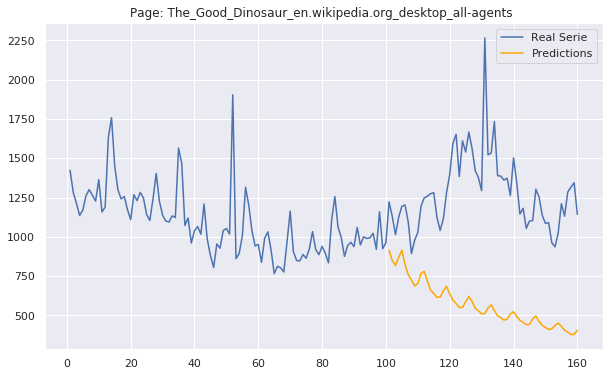

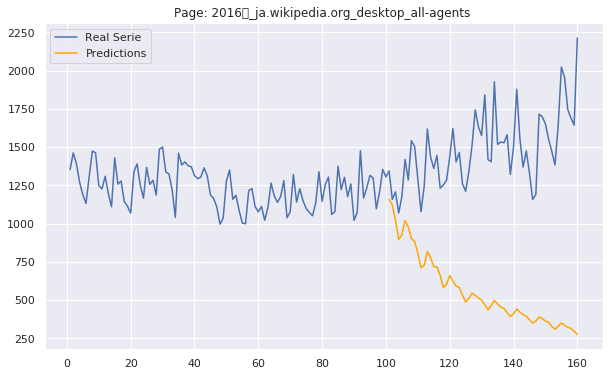

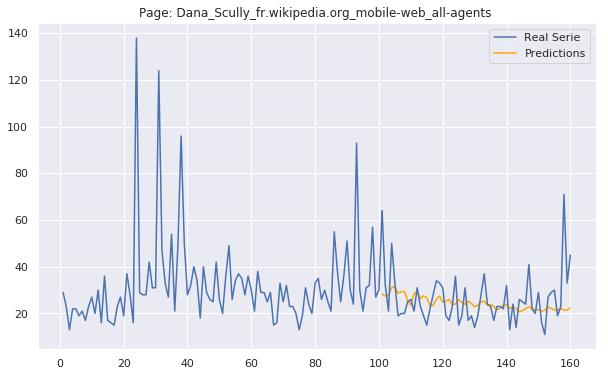

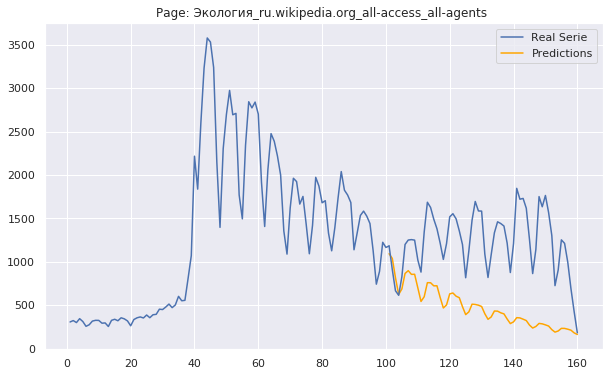

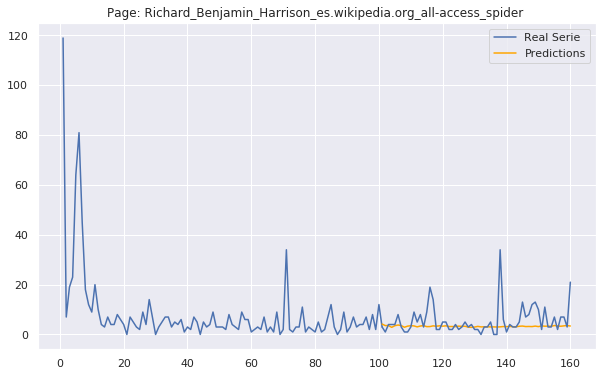

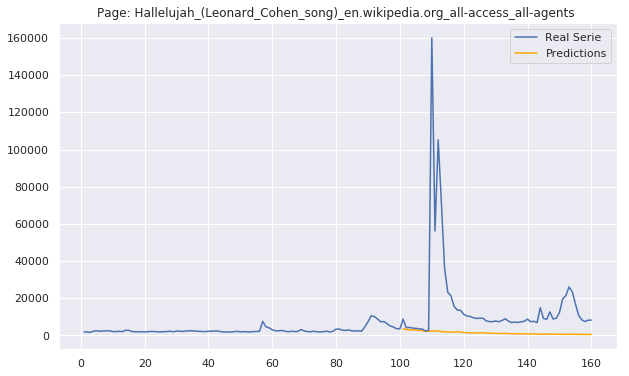

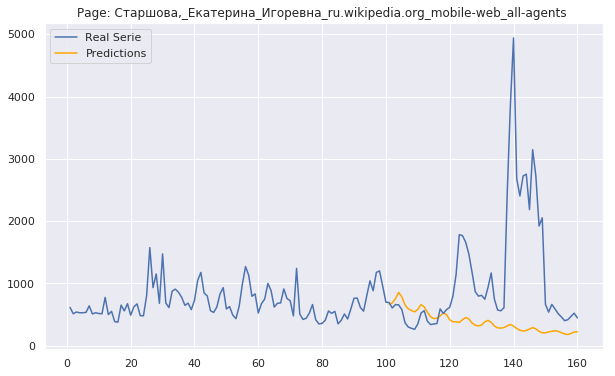

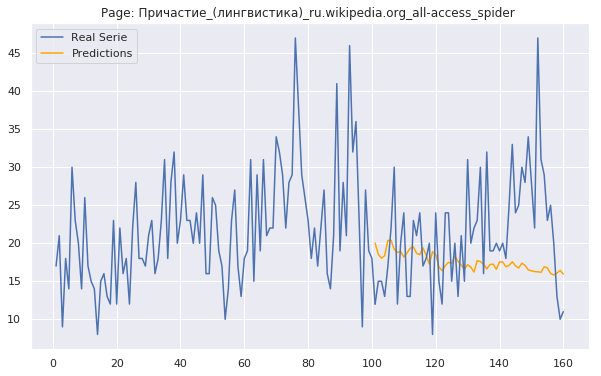

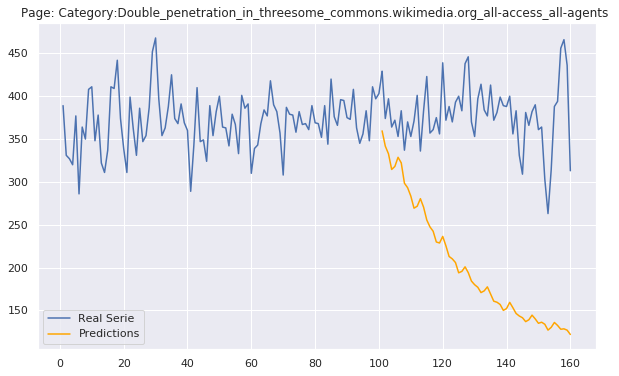

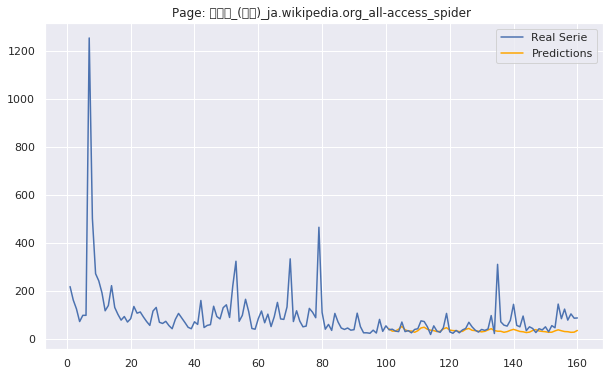

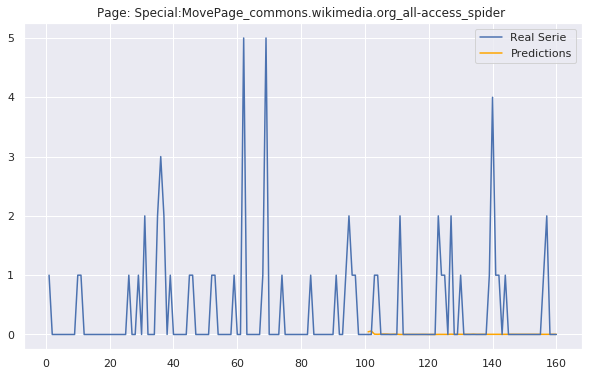

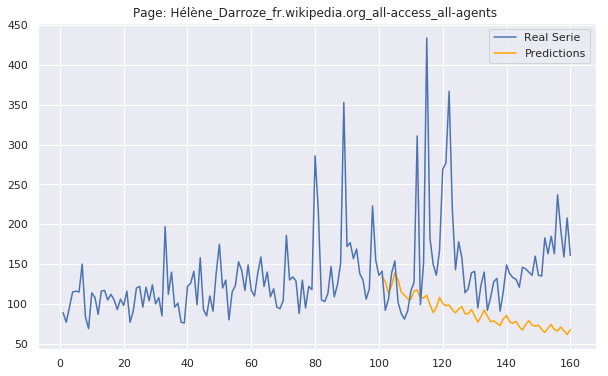

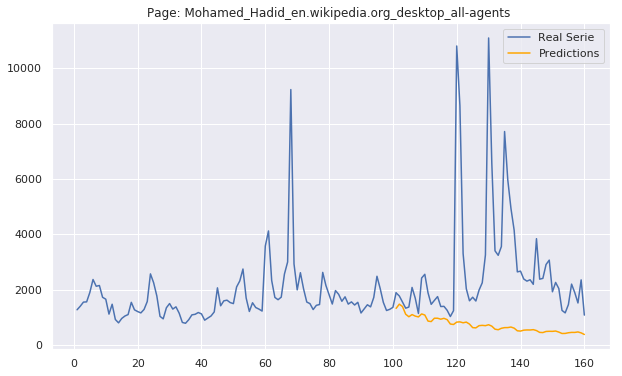

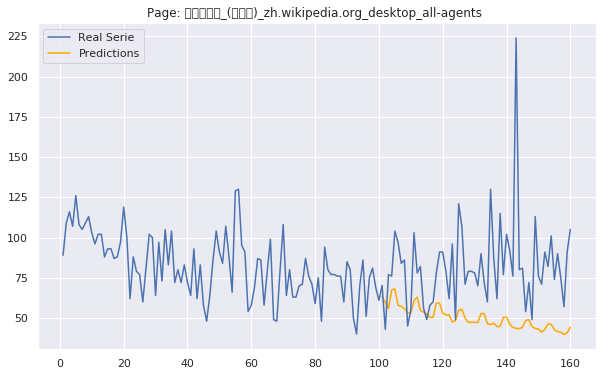

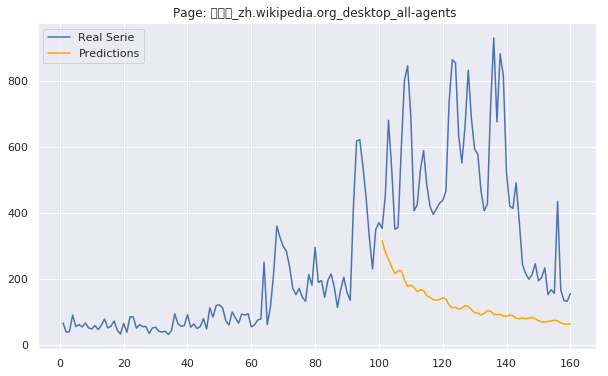

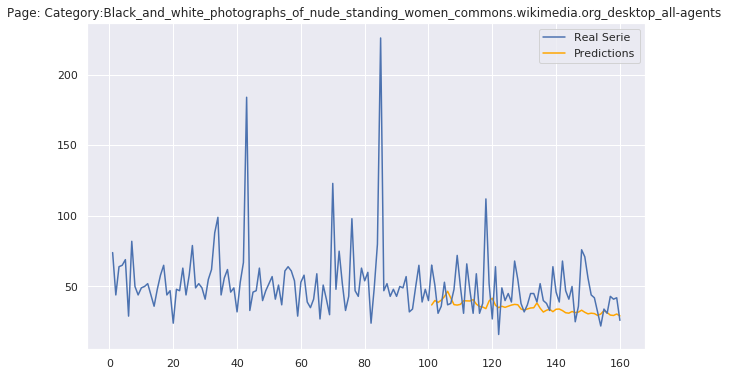

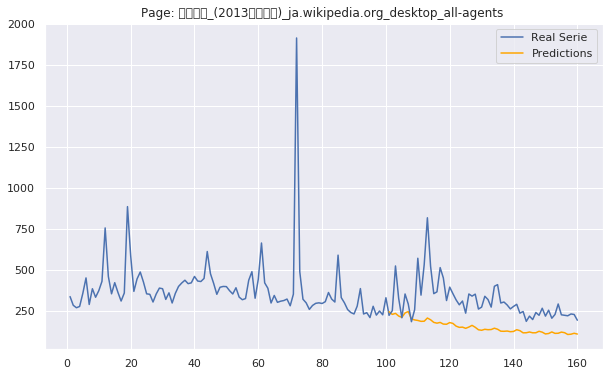

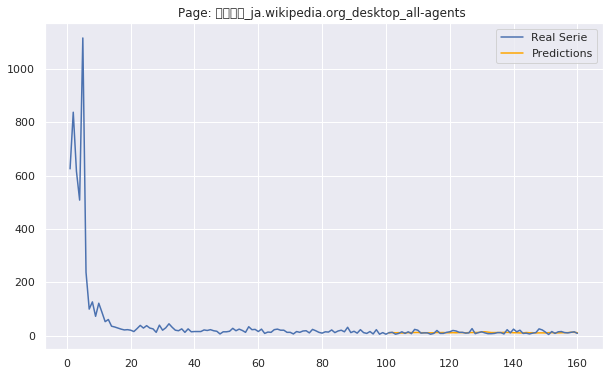

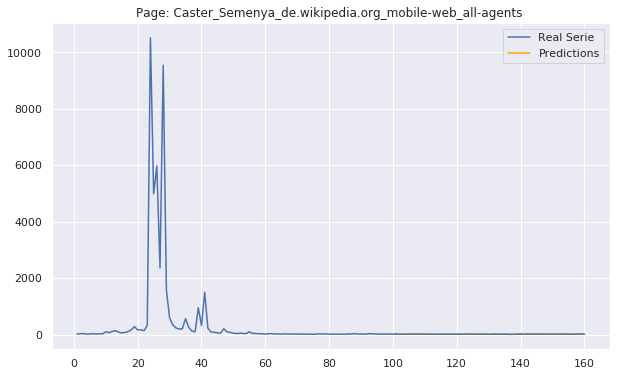

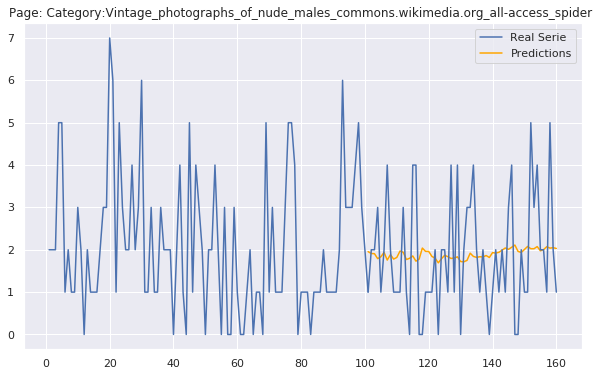

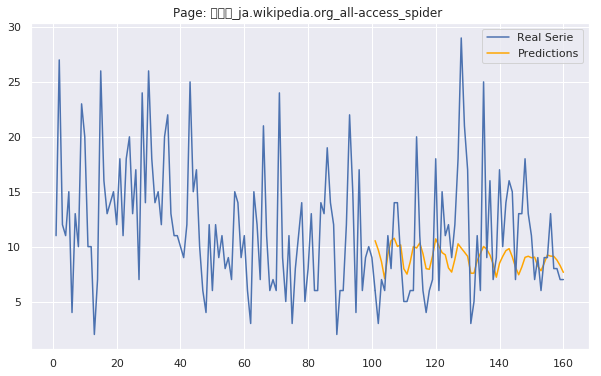

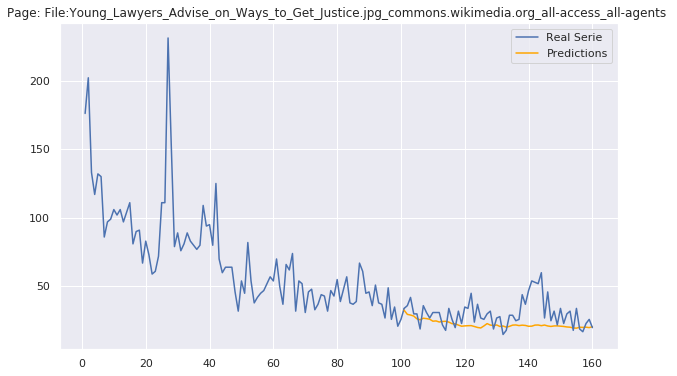

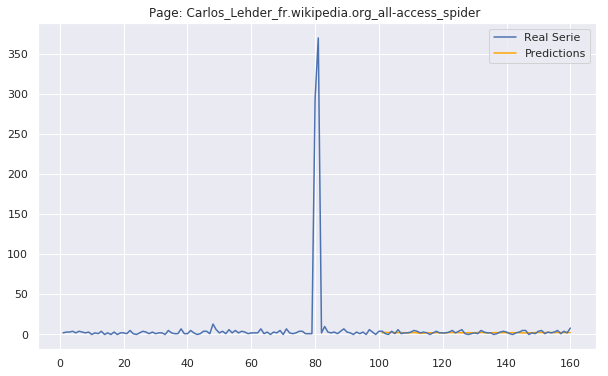

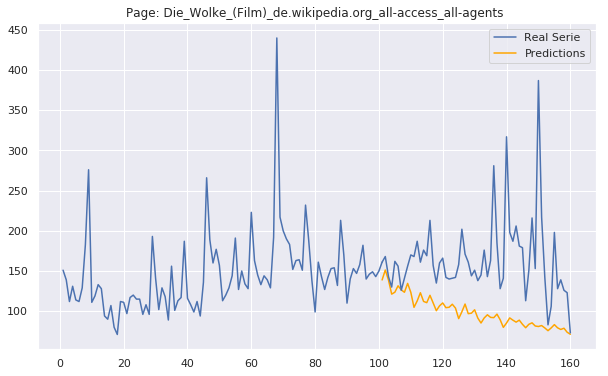

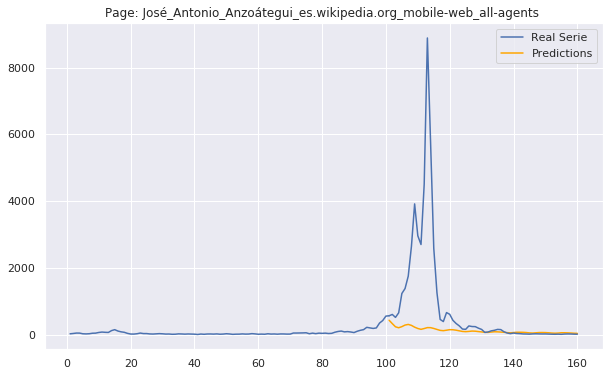

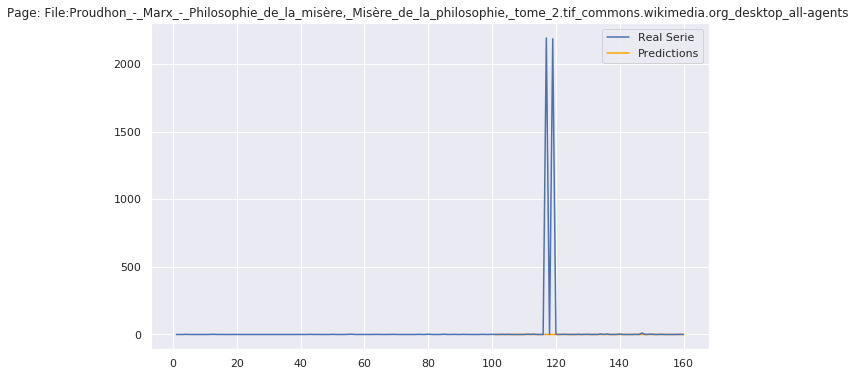

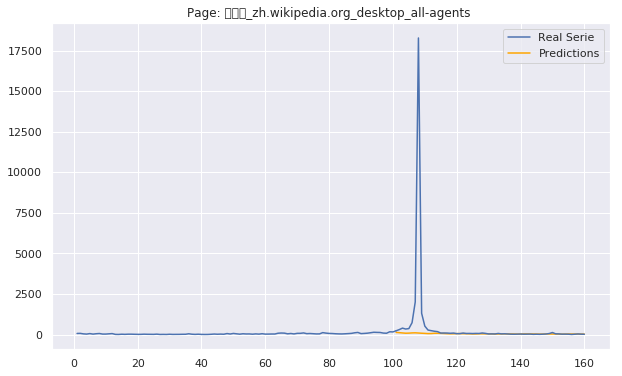

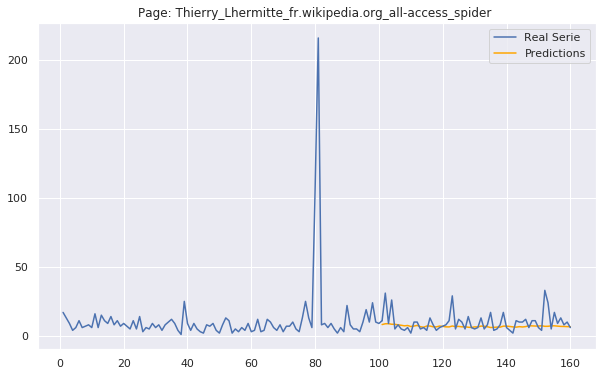

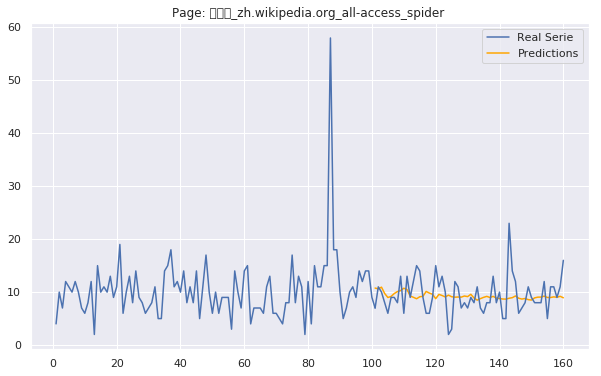

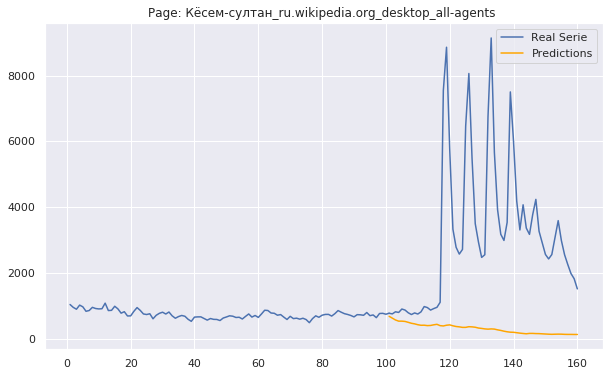

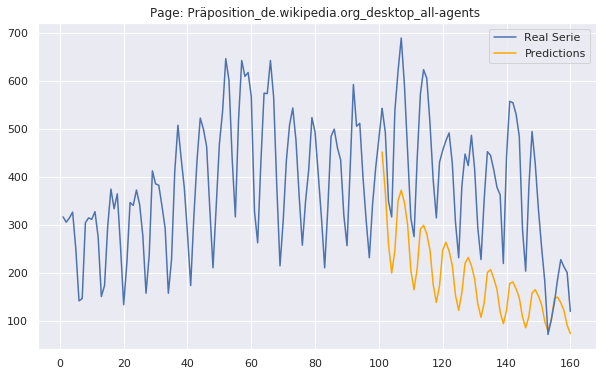

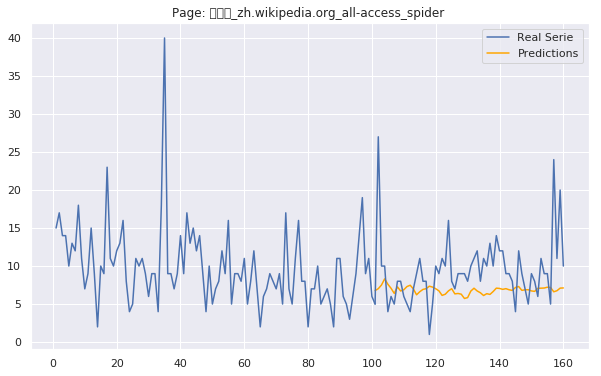

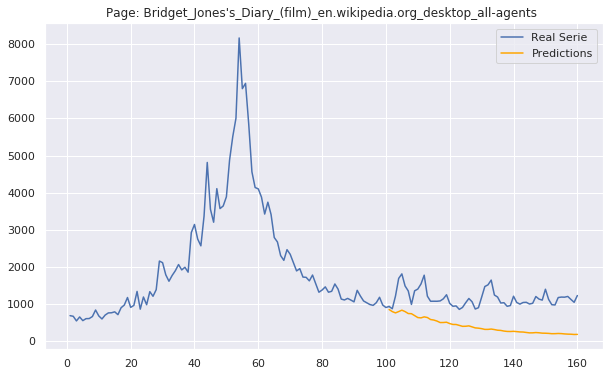

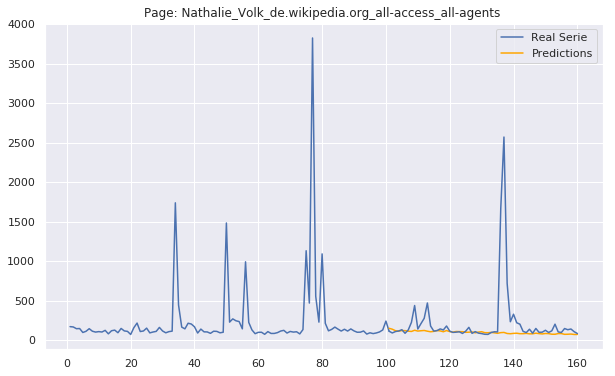

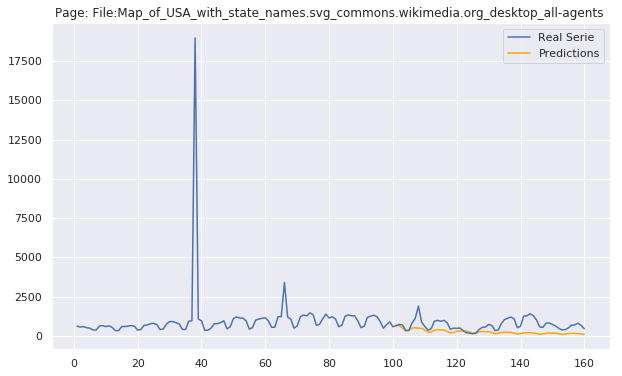

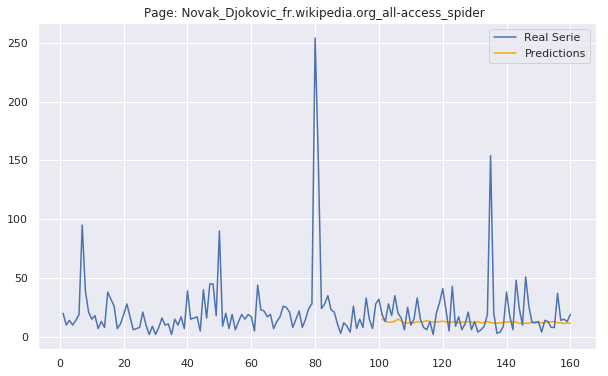

In [17]:
#print 50 random page
from random import randrange
for i in range(50): 
    index = randrange(first_n_samples)
    predict_and_plot_only(encoder_input_data, decoder_target_data, sample_ind=index, enc_tail_len=100)

Sample ind:  4780 Smape:  5.203914091110965


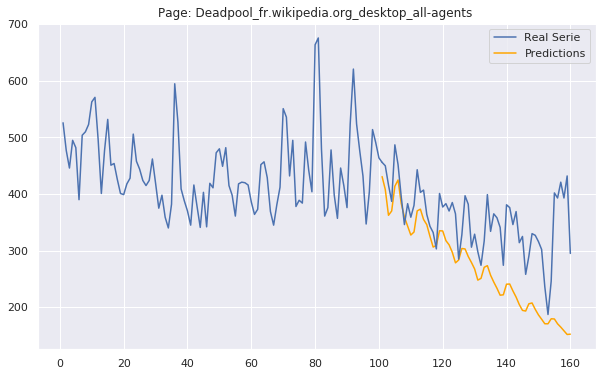

In [18]:
predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=4780, enc_tail_len=100)

Sample ind:  4780 Smape:  5.203914091110965


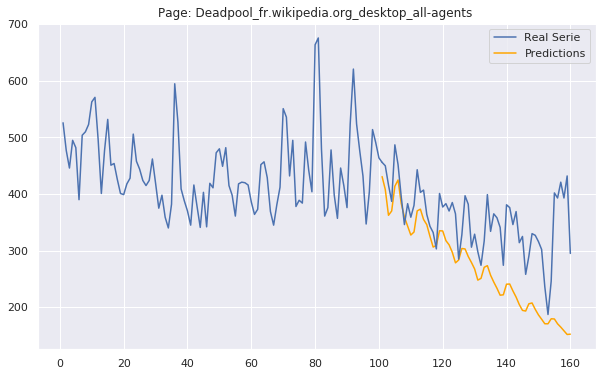

In [19]:
predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=4780, enc_tail_len=100)

Sample ind:  139 Smape:  4.672763343398329


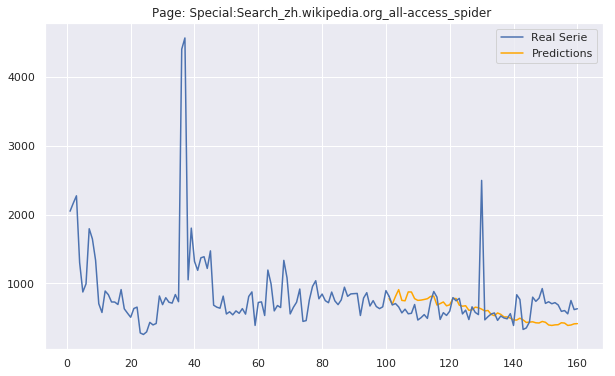

In [20]:
predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=139, enc_tail_len=100)

Sample ind:  913 Smape:  200.0


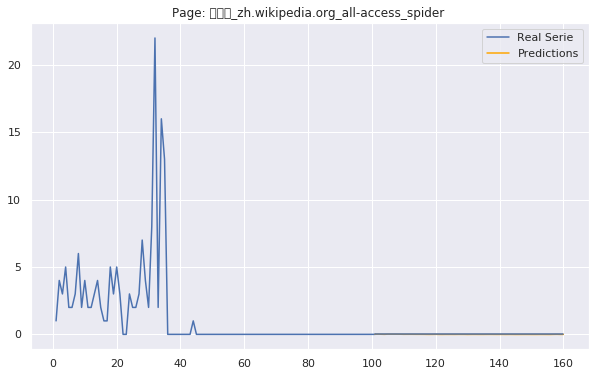

In [21]:
predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=913, enc_tail_len=100)

Sample ind:  16534 Smape:  7.345706461013303


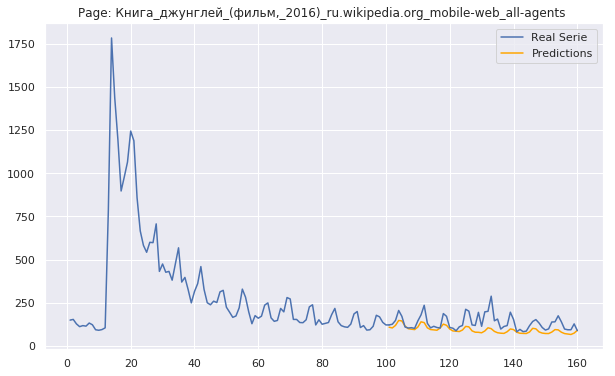

In [22]:
predict_and_plot(encoder_input_data, decoder_target_data, sample_ind=16534, enc_tail_len=100)

Sample ind:  16555 Smape:  12.463095413745842


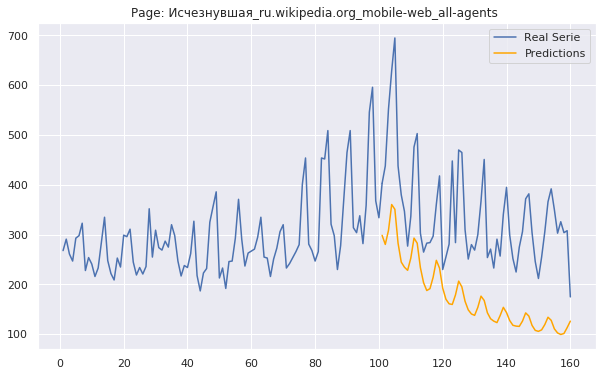

In [23]:
predict_and_plot(encoder_input_data,decoder_target_data,sample_ind=16555, enc_tail_len=100)


Sample ind:  4000 Smape:  20.447374583839423


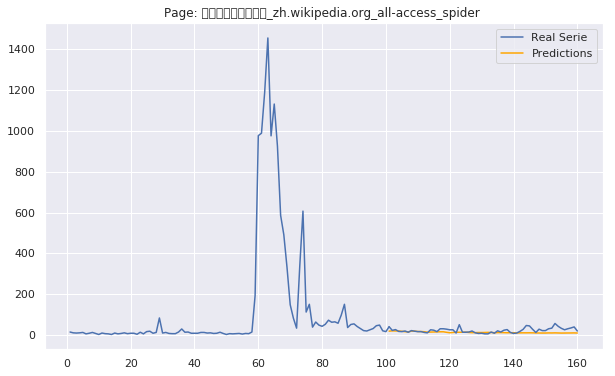

In [24]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=4000, enc_tail_len=100)

Sample ind:  68000 Smape:  15.255056878808302


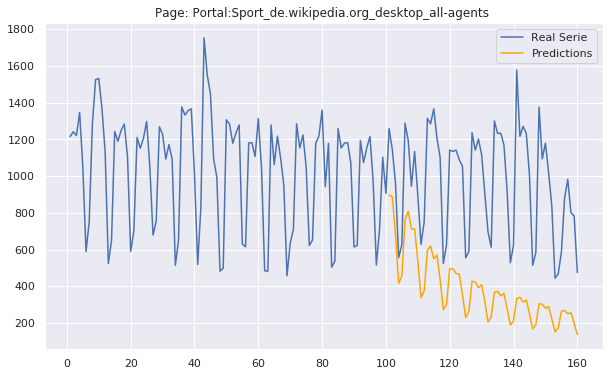

In [25]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=68000, enc_tail_len=100)

Sample ind:  6007 Smape:  13.579880259810746


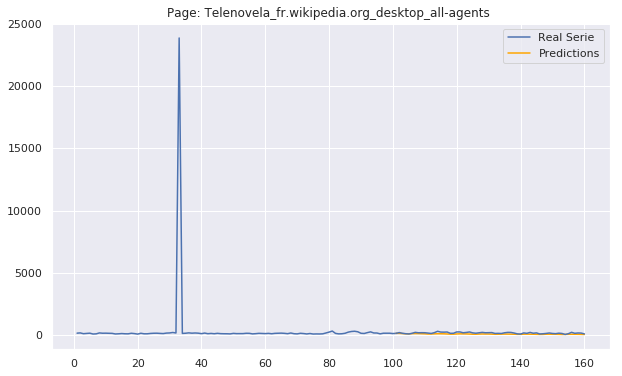

In [26]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=6007, enc_tail_len=100)


Sample ind:  70450 Smape:  12.136431487935209


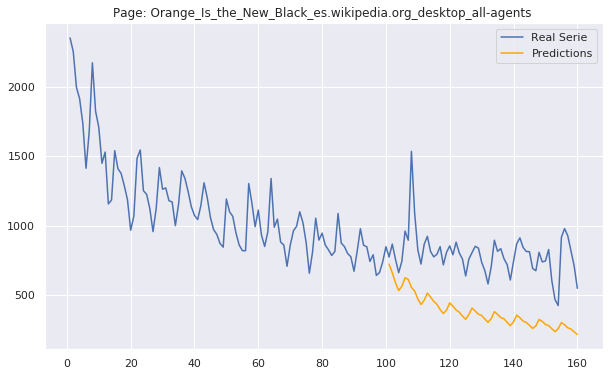

In [27]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=70450, enc_tail_len=100)